### Reproduction of charts in Lloyd-Smith et al



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma

### Fig. 2a

### Method of moments to find shape and scale params

For the gamma distribution, let:

$ \alpha $ be shape

$ \beta $ be scale

Since Lloyd-Smith et al said they used gamrnd, which implements the [gamma distribution pmf](https://au.mathworks.com/help/stats/gamma-distribution.html), then it has these moments:

$ \mu = \alpha \beta $

$ \sigma^2 = \alpha \beta^2 $

Then using the Method of Moments:

$ \alpha = \frac{\mu^2}{\sigma^2} $

$ \beta = \frac{\sigma^2}{\mu} $

Let $ k $ be the index of dispersion:

$ k = \frac{\sigma^2}{\mu} $

And let $ \mu = R_0 $

Then 

$ \alpha = \frac{R_0}{k} $

$ \beta = k $

But the only way that we can reproduce the chart by Lloyd and others (first chart on left, above) is to use:

$ \alpha = k $

$ \beta = \frac{R_0}{k} $


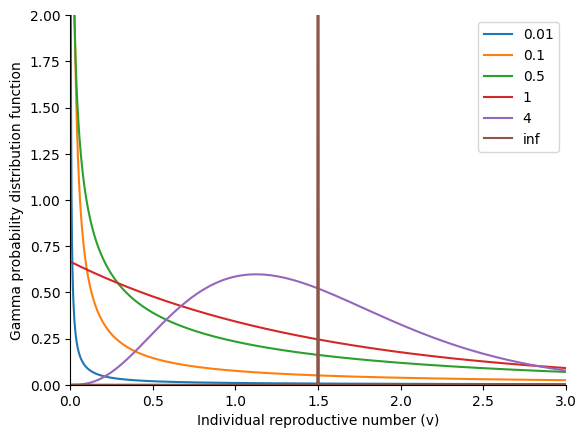

In [2]:
from scale_parameters import to_shape_scale

R0 = 1.5
k_dispersion_labels = [0.01, 0.1, 0.5, 1, 4, "inf"]

parameters = to_shape_scale(k_dispersion_labels, R0) # 10**7 serves as an approximation for inf

resolution = 1000
v = np.linspace(0, 3.0, num=resolution)

_, ax = plt.subplots(nrows=1)

for key in parameters.keys():
    shp = parameters[key]["shape"]
    scl = parameters[key]["scale"]
    
    y = gamma.pdf(v, a=shp, scale=scl)
    ax.plot(v, y)
    
plt.xlabel("Individual reproductive number (v)")
plt.ylabel("Gamma probability distribution function")
ax.spines[['right', 'top']].set_visible(False)
plt.ylim(0, 2)
plt.xlim(0, 3)
ax.legend(k_dispersion_labels)
plt.show()

### Fig. 2b

For $ v \sim gamma, Z \sim poisson(v) $, then this is the NegBim distribution with parameters $ R_0, k $

This has the probability generating function:

$ g(s) = \left\{ 1 + \frac{R0}{k}(1 - s)^{-k} \right\} $

Note that $ g_{n+1}(s)=g(g_n(s)) $ is a monotonially increasing function, since the probability of extinction at or before generation $ n $ is monotinically increasing, since the probability at generation $ n+1 > n $. Since all probabilities are in $ [0,1] $ then the pgf as a series converges to some finite value. Then, $ p = g(p) $

By the fixed point theorem, there exists a fixed point where $ p = p $ is the same value as $ p = g(p) $

Then we can use fixed point iteration to numerically find $ p $, given predifined values for $ k, R_0 $



In [3]:
def g(s, R0, k):
    return (1 + R0/k *(1 - s))**(-k)

def fixed_point_iteration(g, R0_i, k):
    # Burden, Annette & Burden, Richard & Faires, J.. (2011). Numerical Analysis, 9th ed.

    p0 = 0.5 # this is a safe bet, since probabilities in [0,1]
    tolerance = 0.0001
    N = 1000 # max iterations

    for i in range(1,N):
        p = g(p0, R0_i, k)
        if abs(p - p0) < tolerance:
            return p
            break
        p0 = p

def generate_for_k(g, R0, k):
    p_series = []
    for _, R0_i in enumerate(R0):
        p = fixed_point_iteration(g, R0_i, k)
        p_series.append(p)
    return p_series

R0_linspace = []
for i in range(1, 50000):
    R0_linspace.append(i/10000)

numerical_extinction_probability = {
    "0.01": [],
    "0.1": [],
    "0.5": [],
    "1": [],
    "4": [],
    "inf": [] # close as inf as I can get
}

for k in k_dispersion_labels:
    if k == "inf":
        # Note, that the g(s) function returns strange results when k > 10**12... is this some kind of float error?
        numerical_extinction_probability["inf"] = generate_for_k(g, R0_linspace, 10**12)
    else:
        numerical_extinction_probability[str(k)] = generate_for_k(g, R0_linspace, k)

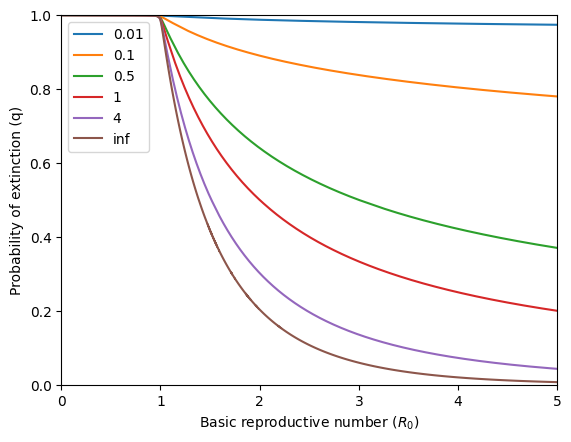

In [4]:
_, ax = plt.subplots(nrows=1)
for _, k in enumerate(k_dispersion_labels):
    ax.plot(R0_linspace, numerical_extinction_probability[str(k)])
ax.legend(k_dispersion_labels)
plt.xlabel("Basic reproductive number ($R_0$)")
plt.ylabel("Probability of extinction (q)")
#ax.spines[['right', 'top']].set_visible(False)
plt.xlim([0, 5])
plt.ylim([0, 1])
plt.show()

### Fig. 2c

In [5]:
R0 = 1.5

from simulation import simulate_outbreak
from poisson_process_generator import PoissonProcessGenerator

k_dispersion_labels.reverse() # It's easier to plot if inf goes first

R0 = 1.5
parameters = to_shape_scale(k_dispersion_labels, R0)

k_simulation_data = {}
k_simulation_data["extinct_generation_counts"] = {}
k_simulation_data["reached_target_generation_counts"] = {}
k_simulation_data["extinct_populations"] = {}
k_simulation_data["reached_target_populations"] = {}
k_simulation_data["first_outbreak_to_reach_target"] = {}
k_simulation_data["number_of_outbreaks_before_target_reached"] = {}
k_simulation_data["extinction_tally"] = {}
k_simulation_data["outbreaks"] = {}
k_simulation_data["survival_rate"]= {}
for k in parameters.keys():
    k_simulation_data["extinct_generation_counts"][k] = []
    k_simulation_data["reached_target_generation_counts"][k] = []
    k_simulation_data["extinct_populations"][k] = []
    k_simulation_data["reached_target_populations"][k] = []
    k_simulation_data["first_outbreak_to_reach_target"][k] = []

for k in parameters.keys():

    print("simulating R0:", R0, "k:", k)
    
    first_outbreak_to_reach_target = None
    extinction_tally = 0
    poisson_process_generator = PoissonProcessGenerator(shape=parameters[k]["shape"], scale=parameters[k]["scale"])
    
    target = 100
    max_outbreaks = 10000
    
    for j in range(1,max_outbreaks+1):

        outbreak = simulate_outbreak(poisson_process_generator, target)
        if outbreak["extinct"] is True:
            extinction_tally = extinction_tally + 1
            k_simulation_data["extinct_generation_counts"][k].append(len(outbreak["history"])-1) # First generation of 1 is gen=0
            k_simulation_data["extinct_populations"][k].append(outbreak["population"])
        else:
            k_simulation_data["reached_target_generation_counts"][k].append(len(outbreak["history"])-1)
            k_simulation_data["reached_target_populations"][k].append(outbreak["population"])
            
        if outbreak["extinct"] is False and len(k_simulation_data["first_outbreak_to_reach_target"][k]) == 0:
            k_simulation_data["first_outbreak_to_reach_target"][k] = outbreak["history"]
            k_simulation_data["number_of_outbreaks_before_target_reached"][k] = j
            
    k_simulation_data["extinction_tally"][k] = extinction_tally
    k_simulation_data["outbreaks"][k] = max_outbreaks
    k_simulation_data["survival_rate"][k] = 1 - (extinction_tally/max_outbreaks)

simulating R0: 1.5 k: inf
simulating R0: 1.5 k: 4
simulating R0: 1.5 k: 1
simulating R0: 1.5 k: 0.5
simulating R0: 1.5 k: 0.1
simulating R0: 1.5 k: 0.01


In addition to the chart "Fig. 2c" in Lloyd et al, we can devise some more:
- Outbreak sizes before target reached           (box plot)
- Outbreak sizes before extinct                  (box plot)
- Distribution of generation that reaches target (box plot) DONE
- Generations before target reached              (box plot)
- Generations before extinct                     (box plot)
- Simulations before target reached (table)
      - Combine with survival rate  (table)

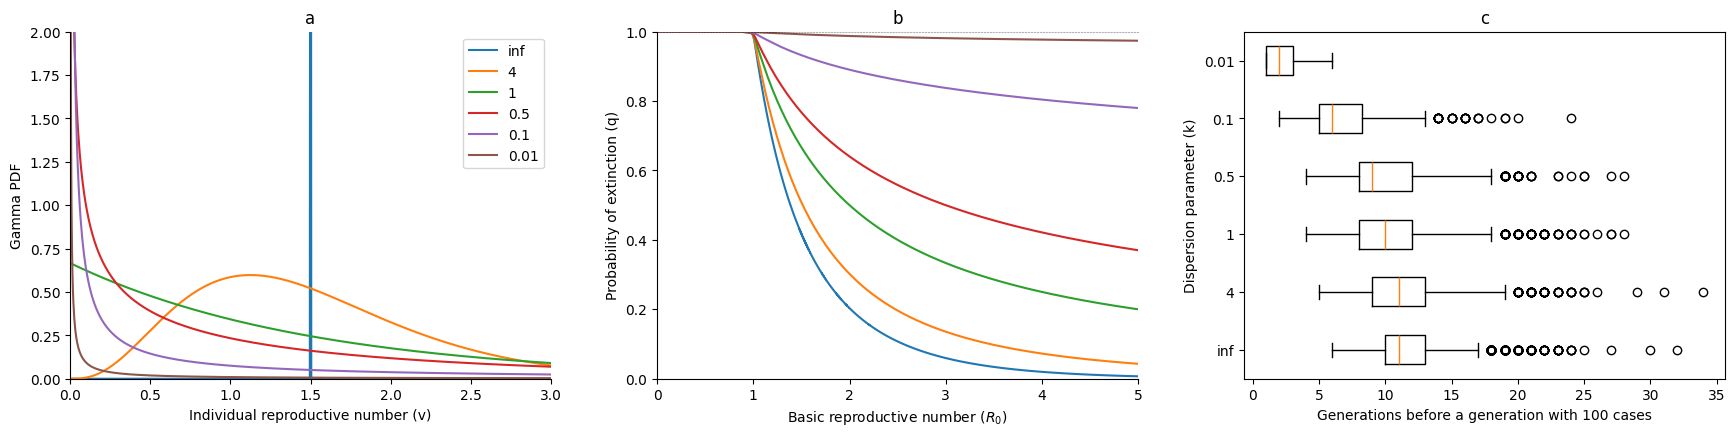

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=False)

# Fig 2a

resolution = 1000
v = np.linspace(0, 3.0, num=resolution)

for key in parameters.keys():
    shp = parameters[key]["shape"]
    scl = parameters[key]["scale"]
    y = gamma.pdf(v, a=shp, scale=scl)
    axs[0].plot(v, y)

axs[0].set_title("a")
axs[0].set_xlabel("Individual reproductive number (v)")
axs[0].set_ylabel("Gamma PDF")
axs[0].set_xlim(0,3)
axs[0].set_ylim(0,2)
axs[0].legend(k_dispersion_labels)
axs[0].spines[['right', 'top']].set_visible(False)

# Fig 2b

for _, k in enumerate(k_dispersion_labels):
    axs[1].plot(R0_linspace, numerical_extinction_probability[str(k)])
axs[1].set_title("b")
axs[1].set_xlabel("Basic reproductive number ($R_0$)")
axs[1].set_ylabel("Probability of extinction (q)")
axs[1].set_xlim([0, 5])
axs[1].set_ylim([0, 1])
axs[1].spines[['top']].set_alpha(0.3)
axs[1].spines[['top']].set_linestyle(':')
axs[1].spines[['right']].set_visible(False)

# Fig 2c

axs[2].boxplot(list(k_simulation_data["reached_target_generation_counts"].values()), tick_labels=k_dispersion_labels, vert=False)
axs[2].set_xlabel("Generations before a generation with 100 cases")
axs[2].set_ylabel("Dispersion parameter (k)")
axs[2].set_title("c")

fig.tight_layout(pad=3.0)

#axs[2].boxplot(k_simulation_data[k]["reached_target_generation_counts"], tick_labels=["inf", 4, 1, 0.5, 0.1, 0.01], vert=False)
#axs[2].set_xlim(-10, 350)
#axs[2].set_xlabel("First generation with 100 cases")
#axs[2].set_ylabel("Dispersion parameter (k)")
#axs[2].set_title("d")

### Other charts

These are not in the paper, but will still be useful to show the reader

In [7]:
df_table = pd.DataFrame({
    "k": k_dispersion_labels,
    "Survival rate": list(k_simulation_data["survival_rate"].values()),
    "Outbreaks before target reached": list(k_simulation_data["number_of_outbreaks_before_target_reached"].values())
})

df_table.style \
        .format(precision=2, thousands=",", decimal=".") \
        .hide(axis="index") \
        .set_properties(**{'text-align': 'left'}, subset=['k']) \
        .set_properties(**{'font-weight': 'bold'}, subset=['k'])
        #.relabel_index(k_dispersion_labels, axis=0)

k,Survival rate,Outbreaks before target reached
inf,0.59,2
4,0.48,1
1,0.34,11
0.50,0.23,5
0.10,0.07,9
0.01,0.01,32


Text(0, 0.5, 'Dispersion parameter (k)')

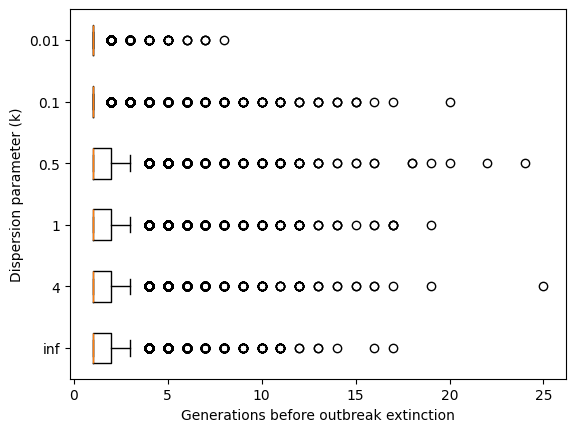

In [8]:
plt.boxplot(list(k_simulation_data["extinct_generation_counts"].values()), tick_labels=k_dispersion_labels, vert=False)
plt.xlabel("Generations before outbreak extinction")
plt.ylabel("Dispersion parameter (k)")
#plt.title("d")

Text(0, 0.5, 'Dispersion parameter (k)')

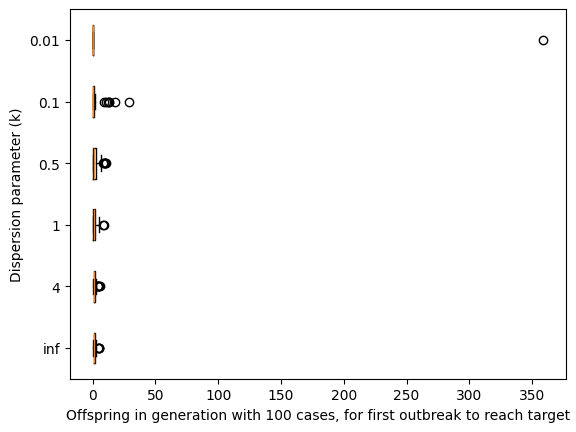

In [9]:
first_successful_generations = []
max_size = 0
for k in k_dispersion_labels:
    first_successful_generation_for_k = k_simulation_data["first_outbreak_to_reach_target"][str(k)][-1]
    first_successful_generations.append(first_successful_generation_for_k)

plt.boxplot(first_successful_generations, tick_labels=k_dispersion_labels, vert=False)
plt.xlabel("Offspring in generation with 100 cases, for first outbreak to reach target")
plt.ylabel("Dispersion parameter (k)")
#plt.title("d")

Text(0.5, 1.0, 'd')

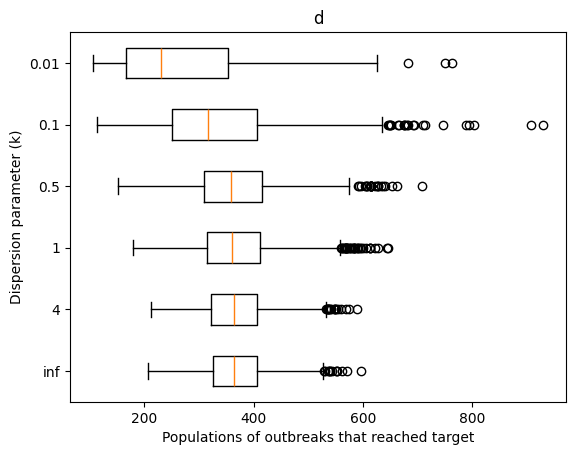

In [10]:
plt.boxplot(list(k_simulation_data["reached_target_populations"].values()), tick_labels=k_dispersion_labels, vert=False)
plt.xlabel("Populations of outbreaks that reached target")
plt.ylabel("Dispersion parameter (k)")
plt.title("d")

Text(0, 0.5, 'Dispersion parameter (k)')

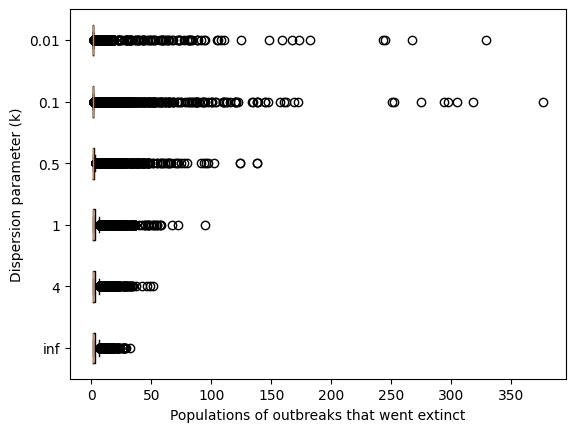

In [11]:
plt.boxplot(list(k_simulation_data["extinct_populations"].values()), tick_labels=k_dispersion_labels, vert=False)
plt.xlabel("Populations of outbreaks that went extinct")
plt.ylabel("Dispersion parameter (k)")
#plt.title("d")